In [1]:
import numpy as np

import torch
from torch import nn
from torch import functional as F

from livelossplot import PlotLosses

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from Inference import BBVI 

In [3]:
from Inference.BBVI import VariationalNetwork

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
sigma_noise = 0.1
data = torch.load('Data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [27]:
class MixtureVariationalNetwork(nn.Module):
    def __init__(self, input_size, output_size, layer_width, nb_layers, device=None):
        super(MixtureVariationalNetwork, self).__init__()
        
        self.layer_width = layer_width
        self.input_size = input_size
        self.output_size = output_size
        self.nb_layers = nb_layers
        self.device = device
        
        self.components = []
        self.pi = torch.tensor([], device=device)
        
    def add_component(self, component, proportion):
        #todo check compatibility with other components
        component.requires_grad_rhos(False)
        component.requires_grad_mus(False)
        self.components.append(component)
        proportion = proportion.to(self.device)
        self.pi = torch.cat((self.pi*(1-proportion), proportion.unsqueeze(0)))
        self.pi.require_grad = False
        
    def sample_parameters(self, M=1):
        D = torch.distributions.multinomial.Multinomial(M, self.pi)
        m = D.sample()
        S = []
        for j in range(len(self.pi)):
            t = self.components[j].sample_parameters(int(m[j]))
            if int(m[j]) > 0: 
                S.append(t)
        return ([torch.cat([c[0][k] for c in S]) for k in range(self.nb_layers)], [torch.cat([c[1][k] for c in S]) for k in range(self.nb_layers)])
    
    def q_log_pdf(self, layered_w_samples, layered_bias_samples):
        log_q = [c.q_log_pdf(layered_w_samples, layered_bias_samples) for c in self.components]
        return torch.logsumexp(torch.stack(log_q) + torch.log(self.pi).unsqueeze(0).t(), dim=0)

    def prior_log_pdf(self, layered_w_samples, layered_bias_samples):
        log_prior = [c.prior_log_pdf(layered_w_samples, layered_bias_samples) for c in self.components]
        return torch.logsumexp(torch.stack(log_prior) + torch.log(self.pi).unsqueeze(0).t(), dim=0)
    
    def full_elbo(self, x_data, y_data, n_samples_ELBO, sigma_noise, new_component=None, new_proportion=None):   
        p = torch.sigmoid(new_proportion)
        npi = torch.tensor([1.0-p, p], device=self.device)
        D = torch.distributions.multinomial.Multinomial(n_samples_ELBO, npi)
        
        m_oldnew = D.sample()
        
        A = self.sample_parameters(m_oldnew[0])
        B = new_component.sample_parameters(m_oldnew[1])
        
        m_oldnew = D.sample()
        S = []
        if int(m_oldnew[0]) > 0:
            S.append(self.sample_parameters(int(m_oldnew[0])))
        if int(m_oldnew[1]) > 0:
            S.append(new_component.sample_parameters(int(m_oldnew[1])))

        S = [(layered_w_samples_XC, layered_bias_samples_XC), (layered_w_samples_XN, layered_bias_samples_XN)]
        V = ([torch.cat([c[0][k] for c in S]) for k in range(self.nb_layers)], [torch.cat([c[1][k] for c in S]) for k in range(self.nb_layers)])
        
        return V
        
    def compute_elbo(self, x_data, y_data, n_samples_ELBO, sigma_noise, new_component=None, new_proportion=None):
        # sample X^(c)
        (layered_w_samples_XC, layered_bias_samples_XC) = self.sample_parameters(n_samples_ELBO)

        LP_XC = self.prior_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)
        y_pred_XC = self.forward(x_data)
        LL_XC = self._log_norm(y_pred_XC, y_data, torch.tensor(sigma_noise).to(self.device))
        posterior_XC = torch.sum(LP_XC.unsqueeze(-1).unsqueeze(-1) + LL_XC, dim=[1,2])

        qC_log_XC = self.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)
        
        if new_component is None:
            return torch.mean(qC_log_XC - posterior_XC)
        
        p = torch.sigmoid(new_proportion)
        
        qN_log_XC = new_component.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)
        qCN_log_XC = torch.logsumexp(torch.stack([torch.log(torch.tensor(1.0, device=self.device)-p) + qC_log_XC, torch.log(p) + qN_log_XC],dim=0),dim=0)
        
        # sample X_(c+1)
        (layered_w_samples_XN, layered_bias_samples_XN) = new_component.sample_parameters(n_samples_ELBO)
        
        LP_XN = new_component.prior_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        y_pred_XN = new_component.forward(x_data)
        LL_XN = new_component._log_norm(y_pred_XN, y_data, torch.tensor(sigma_noise).to(self.device))
        posterior_XN = torch.sum(LP_XN.unsqueeze(-1).unsqueeze(-1) + LL_XN, dim=[1,2])

        qC_log_XN = self.q_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        
        qN_log_XN = new_component.q_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        qCN_log_XN = torch.logsumexp(torch.stack([torch.log(torch.tensor(1.0, device=self.device)-p) + qC_log_XN, torch.log(p) + qN_log_XN],dim=0),dim=0)
        
        L = (torch.tensor(1.0, device=self.device)-p) * (posterior_XC.mean() - qCN_log_XC.mean()) + p * (posterior_XN.mean() - qCN_log_XN.mean()) 
        
        return -L
    
    def requires_grad_rhos(self, v = False):
        for k in range(len(self.components)):
            self.components[k].requires_grad_rhos(v)
        
    def requires_grad_mus(self, v = False):
        for k in range(len(self.components)):
            self.components[k].requires_grad_mus(v)
    
    def forward(self, x):
        return torch.cat([self.components[k].forward(x) for k in range(len(self.components)) if self.components[k].registered_layers[0].weight_sample is not None and self.components[k].registered_layers[0].weight_sample.shape[0] > 0],dim=0)
    

    def _log_norm(self, x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    
    
    

In [7]:
c1 = VariationalNetwork(1, 1, 20, 2, device=device)

In [8]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.5}

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 2, 'factor': 0.8}

In [9]:
voptimizer = BBVI.VariationalOptimizer(model=c1, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params)

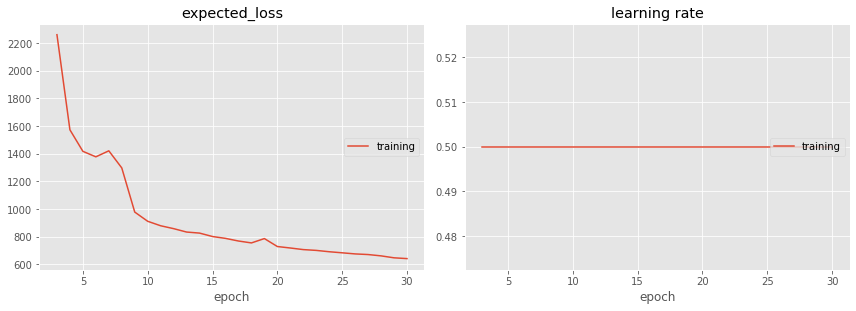

expected_loss:
training   (min:  640.784, max: 795764.688, cur:  640.784)

learning rate:
training   (min:    0.500, max:    0.500, cur:    0.500)


In [10]:
c1 = voptimizer.run((x_data,y_data), n_epoch=30, n_iter=20, n_ELBO_samples=50, plot=True)

In [30]:
mix = MixtureVariationalNetwork(1, 1, 20, 2, device=device)

In [31]:
mix.add_component(c1, torch.tensor(1.0))

In [32]:
new_component = VariationalNetwork(1, 1, 20, 2, device=device)

In [33]:
a = nn.Parameter(torch.tensor(8.0, requires_grad=True, device=device))

In [116]:
self = mix

In [117]:
new_proportion = a

In [118]:
n_samples_ELBO = 1

In [123]:
p = torch.sigmoid(new_proportion)
npi = torch.tensor([1.0-p, p], device=self.device)
D = torch.distributions.multinomial.Multinomial(n_samples_ELBO, npi)

m_oldnew = D.sample()
S = []
if int(m_oldnew[0]) > 0:
    S.append(self.sample_parameters(int(m_oldnew[0])))
if int(m_oldnew[1]) > 0:
    S.append(new_component.sample_parameters(int(m_oldnew[1])))

S = [(layered_w_samples_XC, layered_bias_samples_XC), (layered_w_samples_XN, layered_bias_samples_XN)]
(layered_w_samples_XC, layered_bias_samples_XC) = ([torch.cat([c[0][k] for c in S]) for k in range(self.nb_layers)], [torch.cat([c[1][k] for c in S]) for k in range(self.nb_layers)])

In [124]:
LP_XC = self.prior_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

In [122]:
y_pred_XC = self.forward(x_data)

RuntimeError: expected a non-empty list of Tensors

In [121]:
LL_XC = self._log_norm(y_pred_XC, y_data, torch.tensor(sigma_noise).to(self.device))
posterior_XC = torch.sum(LP_XC.unsqueeze(-1).unsqueeze(-1) + LL_XC, dim=[1,2])

torch.Size([100])